In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import orbipy as op
import pyintersection as pyi

import manifold_generator as mg
import plotting

In [328]:
model = op.crtbp3_model()
pltr = op.plotter.from_model(model, length_units='Mm')
scale = pltr.scaler

halo = np.loadtxt("halo family SE L1.txt")
idx = 282

s0 = model.get_zero_state()
s0[[0, 2, 4]] = halo[idx]

In [3]:
def create_point_generator(s0, dstrb):
    model = op.crtbp3_model()
    udir = op.unstable_direction_stm(op.crtbp3_model(stm=True))
    def generator(n, t):
        s = model.prop(s0, 0., n, ret_df=False)[-1, 1:]
        s[3:] += udir(n, s) * dstrb
        s1 = model.prop(s, 0., t, ret_df=False)[-1, 1:]
        return s1[:3]
    return generator

In [4]:
pts = []
t = 3.5
ns = np.linspace(0, np.pi, 100)
gen = create_point_generator(s0, scale(1, 'm/s-nd/nd'))

for n in ns:
    pts.append(gen(n, t))

pts = np.array(pts)

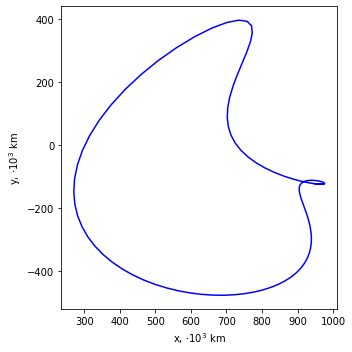

In [5]:
pltr.plot_proj(pts, projections=('x-y',))
plt.show()

In [6]:
def create_manifold_generator(s0,
                              dstrb=scale(1, 'm/s-nd/nd'),
                              points_count=40):
    scaling = 1
    model = op.crtbp3_model()
    udir = op.unstable_direction_stm(op.crtbp3_model(stm=True))
    def generator(nc, tc, atol, points_count=points_count):
        size = int(points_count**0.5)
        twidth = atol * scaling
        nwidth = atol * scaling
        ns = np.linspace(nc - nwidth / 2, nc + nwidth / 2, size)
        ts = np.linspace(tc - twidth / 2, tc + twidth / 2, size)
        res = np.zeros((size, size, 5))

        for i, n in enumerate(ns):
            s = model.prop(s0, 0., n, ret_df=False)[-1, 1:]
            s[3:] += udir(n, s) * dstrb
            t0 = ts[0] - twidth * 1e-5
            s1 = model.prop(s, 0., t0, ret_df=False)[-1, 1:]
            for j, t in enumerate(ts):
                s2 = model.prop(s1, t0, t, ret_df=False)[-1, 1:]
                res[j, i] = n, t, *s2[:3]
        return res.reshape(-1, 5)
    return generator

In [7]:
gen2 = create_manifold_generator(s0, scale(1, 'm/s-nd/nd'), 64)

In [8]:
res = gen2(np.pi/2, 3., 1., 64**2)

In [9]:
for i in range(res.shape[0]):
    plt.plot(res[i, :, 2], res[i, :, 3])
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
for j in range(res.shape[1]):
    plt.plot(res[:, j, 2], res[:, j, 3])
plt.show()

In [10]:
mg.create_manifold_generator(generate_point=gen)

<function manifold_generator.create_manifold_generator.<locals>.generator(n, t, atol, points_count=40)>

In [11]:
x = model.mu1
[-s0[2], s0[2]]

[-0.0026713487539988283, 0.0026713487539988283]

# Optimize with static manifold

## Define new optime3d function

In [12]:
def _get_manifold_number(rpoint):
    return rpoint[1]

def _get_rpoint_params(rpoint):
    return rpoint[2], rpoint[3]

def _get_cid(rpoint):
    return rpoint[0]

In [253]:
def _generate_new_points(rpoints, atol=None, agen=None, bgen=None, ucid=False,
                         a_scaling=1, b_scaling=1):
    usedcids = set()
    ares, bres = [], []
    for rpoint in rpoints:
        n, t = _get_rpoint_params(rpoint)
        manifold = _get_manifold_number(rpoint)
        ####
        if ucid:
            cid = _get_cid(rpoint)
            if (cid, manifold) in usedcids:
                continue
            usedcids.add((cid, manifold))
        ####
        if manifold == 0:
            if a_scaling is not None:
                new_points = agen(n, t, atol, scaling=a_scaling)
            else:
                new_points = agen(n, t, atol)
            ares.append(new_points)
        elif manifold == 1:
            if b_scaling is not None:
                new_points = bgen(n, t, atol, scaling=b_scaling)
            else:
                new_points = bgen(n, t, atol)
            bres.append(new_points)
        else:
            raise Exception("Wrong manifold number")
          
    counter = 0
    for nparr in ares:
        for unarr in nparr:
            counter += 1
    ares = np.reshape(np.array(ares), (counter, 5))
            
    counter = 0
    for nparr in bres:
        for unarr in nparr:
            counter += 1
    bres = np.reshape(np.array(bres), (counter, 5))
        
    return ares, bres

def _optimize3d(a, b, target_atol=None, agen=None, bgen=None,
                max_iter=8, tree_depth=2, max_rpoints=10**10, atol_divider=2, ucid=False):
    atol = max(pyi.get_boundary_cube3d(a, b))
    k = atol_divider
    i = 0
    while True:
        print(f'Launch    {i}: target_atols={atol/k} mpoints={len(a) + len(b)}')
        rcubes, rpoints, atols = pyi.intersect3d(a, b, atol=atol/k, tree_depth=tree_depth)
        print(f'Iteration {i}: target_atols={atol/k} real_atols={max(atols)} rpoints={len(rpoints)} rcubes={len(rcubes)}')
        i += 1
        if i >= max_iter or max(atols) <= target_atol:
            break
        atol = max(atols)
        if len(rpoints) > max_rpoints:
            i -= 1
            continue
        a, b = _generate_new_points(rpoints, atol=atol, agen=agen, bgen=bgen, ucid=ucid)
    return rcubes, rpoints, atols

## Create manifolds generator

In [254]:
import plain

In [255]:
plain_norm = np.array([1.0, 0.0, 0.0]) # x y z
plain_par = np.array([0.0, 1.0, 0.0])
plain_offset = np.array([0.0, 0.0, 1.0])

plain_mesh = plain.create_mesh(plain_norm)
plain_point_generator = plain.create_point_generator(plain_par, plain_offset, np.array([model.mu1, 0.0, 0.0]))
plain_mg = mg.create_manifold_generator(plain_point_generator, points_count=100)

l2_mg = create_manifold_generator(s0, scale(1, 'm/s-nd/nd'), points_count=100)

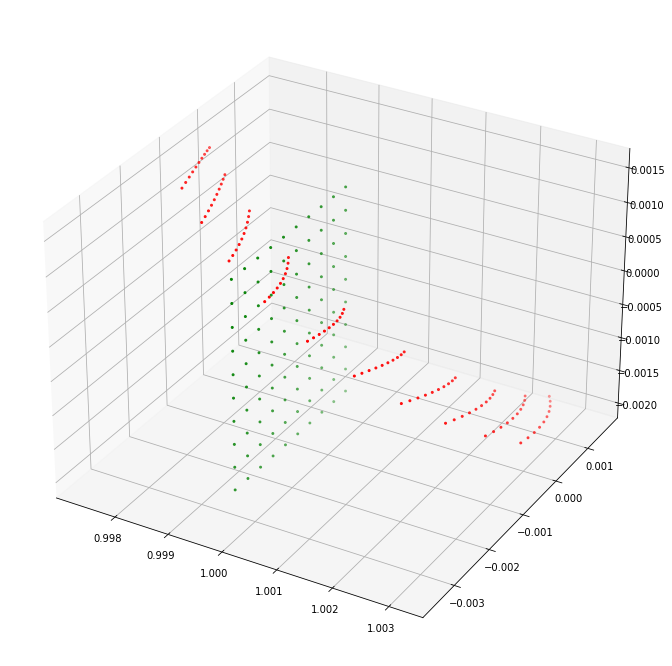

In [256]:
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')

start_plain = plain_mg(0, -0.002, 0.003)
start_l2 = l2_mg(0, 2.8, 0.19)
plotting.plot_mpoints(axis, start_plain, c='g', s=4)
plotting.plot_mpoints(axis, start_l2, c='r', s=4)

Iteration 0: target_atols=1.0 real_atols=1.0 rpoins=71 cubes=4
Iteration 1: target_atols=0.5 real_atols=0.14583333333333334 rpoins=339 cubes=4


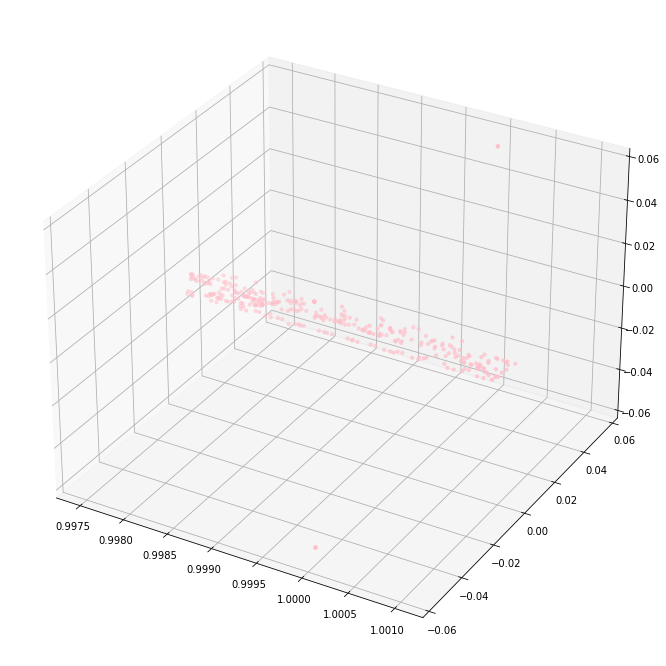

In [49]:
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')

rcubes, rpoints, _ = _optimize3d(start_plain, start_l2, 0.1,
    plain_mg, l2_mg, max_iter=2)

plotting.plot_rpoints(axis, rpoints, c='pink', s=10)
# plotting.plot_mpoints(axis, start_plain, c='g', s=4)
# plotting.plot_mpoints(axis, start_l2, c='r', s=4)

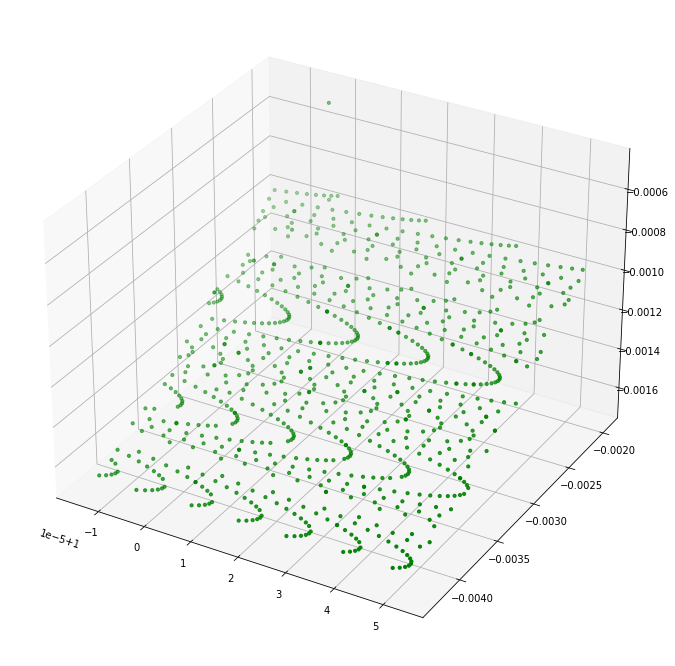

In [70]:
plain_mg = mg.create_manifold_generator(plain_point_generator, points_count=300)
l2_mg = create_manifold_generator(s0, scale(1, 'm/s-nd/nd'), points_count=300)

plain_start = plain_mg(0, 0, 4)
l2_start = l2_mg(np.pi / 2, 0, np.pi)

# rcubes, rpoints, _ = _optimize3d(plain_start, l2_start, 0.0001,
#     plain_mg, l2_mg, max_iter=3, tree_depth=1)


fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)

## Manifold generator for plain (density)

In [257]:
def create_manifold_generator_density(generate_point=None, points_count=40, scaling=1):
    def generator(n, t, atol, points_count=points_count, scaling=scaling):
        size = int(points_count**0.5)
        twidth = atol * scaling
        nwidth = atol * scaling
        ts = np.linspace(t - twidth / 2, t + twidth / 2, size)
        ns = np.linspace(n - nwidth / 2, n + nwidth / 2, size)
        res = np.zeros((len(ns) * len(ts), 5))

        for i, n in enumerate(ns):
            for j, t in enumerate(ts):
                res[j + len(ts) * i] = n, t, *generate_point(n, t)
        return res
    return generator

In [342]:
# def create_l2_manifold_generator(s0,
#                               dstrb=scale(1, 'm/s-nd/nd'),
#                               points_count=40, scaling=1.):
#     model = op.crtbp3_model()
#     udir = op.unstable_direction_stm(op.crtbp3_model(stm=True))
#     def generator(nc, tc, atol, points_count=points_count, scaling=scaling):
#         size = int(points_count**0.5)
#         twidth = atol * scaling * 0.1
#         nwidth = atol * scaling
#         ns = np.linspace(nc - nwidth / 2, nc + nwidth / 2, size)
#         ts = np.linspace(tc - twidth / 2, tc + twidth / 2, size)
#         res = np.zeros((size, size, 5))

#         for i, n in enumerate(ns):
#             s = model.prop(s0, 0., n, ret_df=False)[-1, 1:]
#             s[3:] += udir(n, s) * dstrb
#             t0 = ts[0] - twidth * 1e-5
#             s1 = model.prop(s, 0., t0, ret_df=False)[-1, 1:]
#             for j, t in enumerate(ts):
#                 s2 = model.prop(s1, t0, t, ret_df=False)[-1, 1:]
#                 res[j, i] = n, t, *s2[:3]
#         return res.reshape(-1, 5)
#     return generator

In [367]:
def create_l2_manifold_generator(s0,
                              dstrb=scale(1, 'm/s-nd/nd'),
                              points_count=40, scaling=1.):
    model = op.crtbp3_model()
    udir = op.unstable_direction_stm(op.crtbp3_model(stm=True))
    def generator(nc, tc, atol, points_count=points_count, scaling=scaling):
        size = int(points_count**0.5)
        twidth = atol * scaling * 0.1
        nwidth = atol * scaling
        ns = np.linspace(nc - nwidth / 2, nc + nwidth / 2, size)
        ts = np.linspace(tc - twidth / 2, tc + twidth / 2, size)
        res = np.zeros((size, size, 5))

        for i, n in enumerate(ns):
            s = model.prop(s0, 0., n, ret_df=False)[-1, 1:]
            s[3:] += udir(n, s) * dstrb
            t0 = ts[0] - twidth * 1e-5
            s1 = model.prop(s, 0., t0, ret_df=False)[-1, 1:]
            for j, t in enumerate(ts):
                s2 = model.prop(s1, t0, t, ret_df=False)[-1, 1:]
                res[j, i] = n, t, *s2[:3]
        return res.reshape(-1, 5)
    return generator

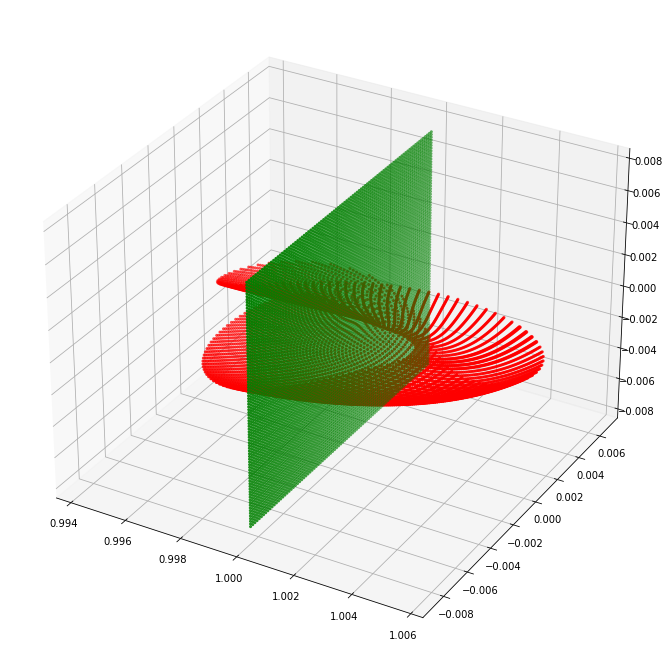

In [413]:
plain_mg = create_manifold_generator_density(plain_point_generator, points_count=16, scaling=1)
l2_mg = create_l2_manifold_generator(s0, scale(1, 'm/s-nd/nd'), points_count=16)

# plain_start = plain_mg(0, 0, 4)
# l2_start = l2_mg(0, 0, 8)

plain_start = plain_mg(0, -0.0011, 0.015, points_count=8000)

l2_start = l2_mg(np.pi/2, 3, np.pi, points_count=10000)

# rcubes, rpoints, _ = _optimize3d(plain_start, l2_start, 0.000001,
#     plain_mg, l2_mg, max_iter=1, max_rpoints=400, atol_divider=2, tree_depth=2, ucid=False)

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_mpoints(axis, plain_start, c='g', s=4)
plotting.plot_mpoints(axis, l2_start, c='r', s=4)
# n t x y z
# plt.scatter(plain_start[:,3], plain_start[:,4], s=4)
# plt.scatter(l2_start[:,3], l2_start[:,4], c='r', s=1)

In [395]:
def mfilter(rpoints, m):
    return np.array([*filter(lambda x: x[1] == m, rpoints)])

Tolerance: 0.00023770101297395513


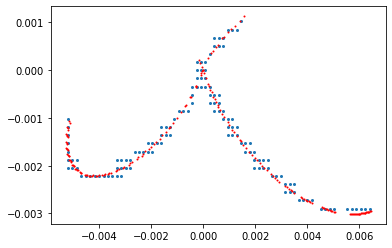

In [414]:
rcubes, rpoints, tols = pyi.intersect3d(plain_start, l2_start, 0.0005, tree_depth=2)
print(f"Tolerance: {max(tols)}")

# fig = plt.figure(figsize=(12, 12))
# axis = fig.add_subplot(111, projection='3d')
# plotting.plot_rpoints(axis, rpoints, c='g', s=10)
# plotting.plot_mpoints(axis, plain_start, c='g', s=4)
# plotting.plot_mpoints(axis, l2_start, c='r', s=4)

arpoints = mfilter(rpoints, 0)
brpoints = mfilter(rpoints, 1)

# 0   1 2 3 4 5 6
# cid m n t x y z

# x projection
plt.scatter(arpoints[:,5], arpoints[:,6], s=4)
plt.scatter(brpoints[:,5], brpoints[:,6], c='r', s=1)

# # y projection
# plt.scatter(arpoints[:,4], arpoints[:,6], s=4)
# plt.scatter(brpoints[:,4], brpoints[:,6], c='r', s=1)

# z projection
# plt.scatter(arpoints[:,4], arpoints[:,5], s=4)
# plt.scatter(brpoints[:,4], brpoints[:,5], c='r', s=1)

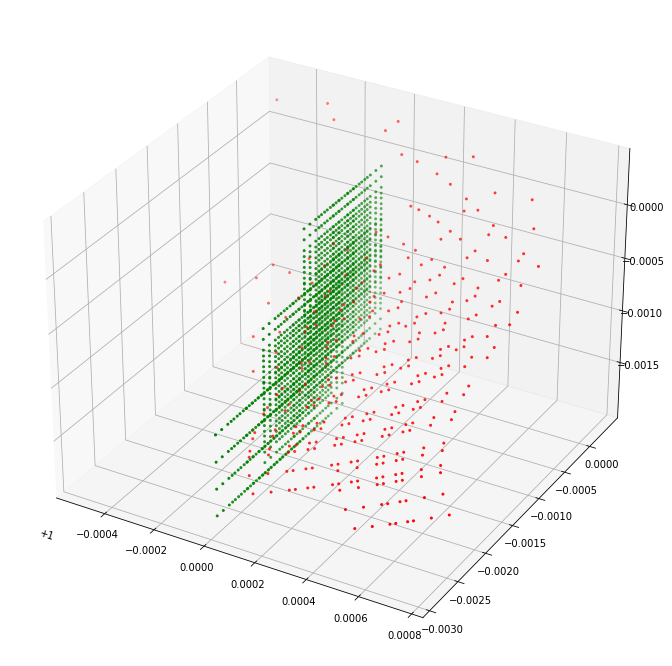

In [361]:
aman, bman = _generate_new_points(rpoints, max(tols), plain_mg, l2_mg, b_scaling=100)

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
#plotting.plot_rpoints(axis, rpoints, c='g', s=10)
plotting.plot_mpoints(axis, aman, c='g', s=4)
plotting.plot_mpoints(axis, bman, c='r', s=4)

Tolerance: 0.0008041581945539187 rcubes=7


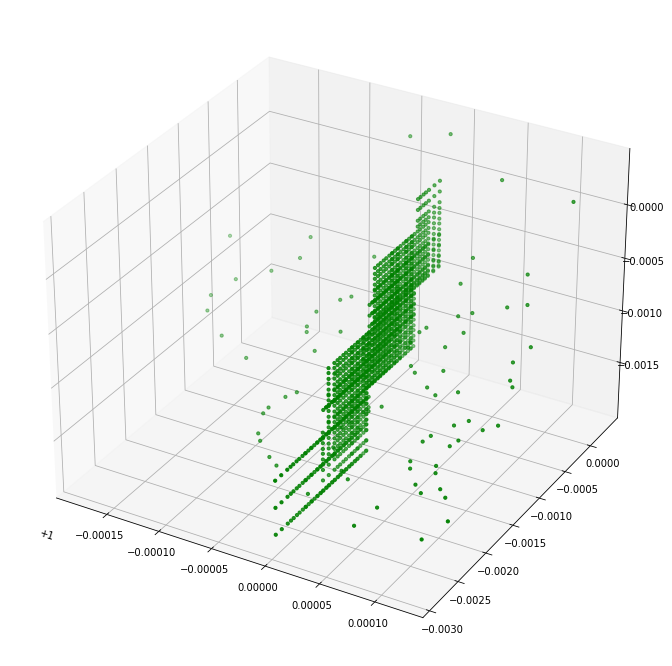

In [362]:
rcubes, rpoints, tols = pyi.intersect3d(aman, bman, 0.001, tree_depth=2)
print(f"Tolerance: {max(tols)} rcubes={len(rcubes)}")

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)
# plotting.plot_mpoints(axis, plain_start, c='g', s=4)
# plotting.plot_mpoints(axis, l2_start, c='r', s=4)

In [279]:
aman, bman = _generate_new_points(rpoints, max(tols), plain_mg, l2_mg)

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)
plotting.plot_mpoints(axis, aman, c='r', s=4)
plotting.plot_mpoints(axis, bman, c='r', s=4)

KeyboardInterrupt: 

In [ ]:
rcubes, rpoints, tols = pyi.intersect3d(aman, bman, 0.001, tree_depth=2)
print(f"Tolerance: {max(tols)} {len(rpoints)}")

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)
# plotting.plot_mpoints(axis, plain_start, c='g', s=4)
# plotting.plot_mpoints(axis, l2_start, c='r', s=4)

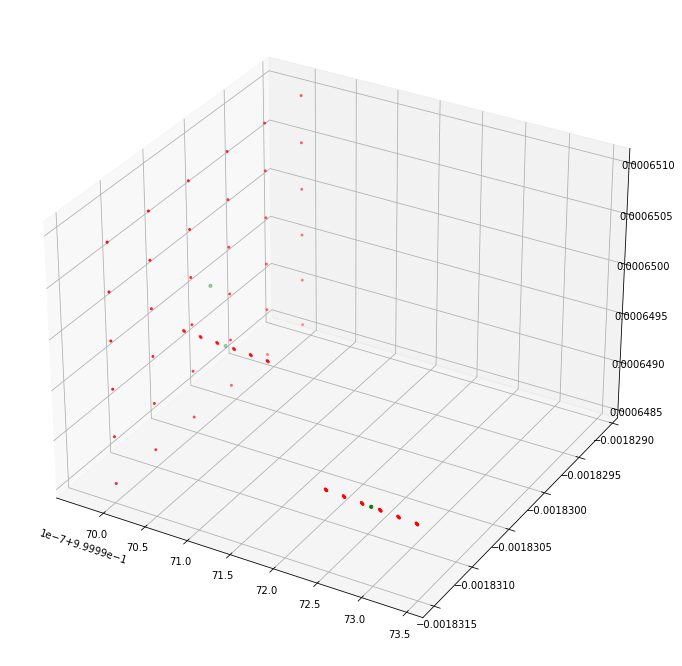

In [268]:
aman, bman = _generate_new_points(rpoints, max(tols), plain_mg, l2_mg)

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)
plotting.plot_mpoints(axis, aman, c='r', s=4)
plotting.plot_mpoints(axis, bman, c='r', s=4)

Tolerance: 2.8489191207988493e-06 349


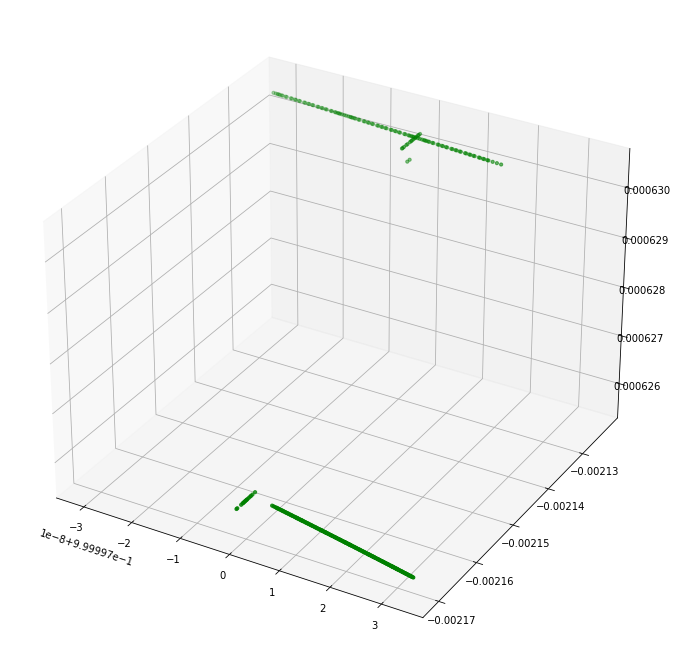

In [237]:
rcubes, rpoints, tols = pyi.intersect3d(aman, bman, 0.000005, tree_depth=2)
print(f"Tolerance: {max(tols)} {len(rpoints)}")

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plotting.plot_rpoints(axis, rpoints, c='g', s=10)
# plotting.plot_mpoints(axis, plain_start, c='g', s=4)
# plotting.plot_mpoints(axis, l2_start, c='r', s=4)